Processing: Game 1 Home
Players detected: 14
Substitutions found: 3


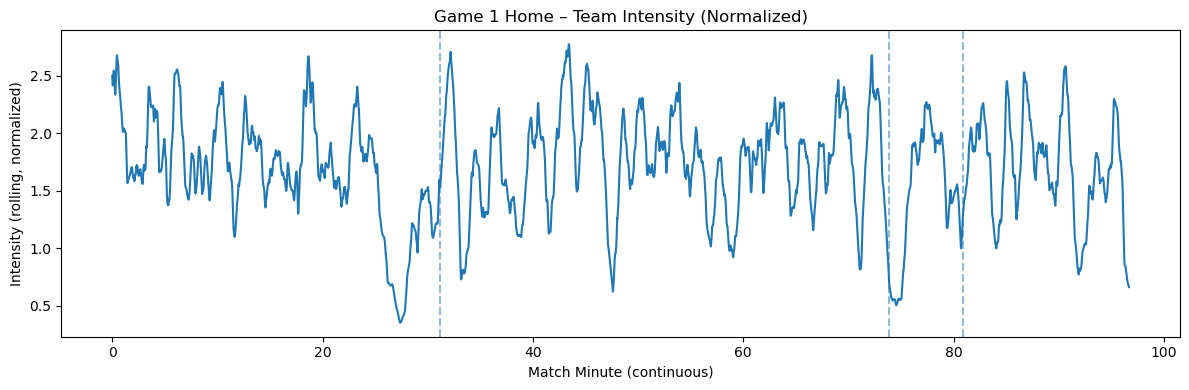

Processing: Game 1 Away
Players detected: 14
Substitutions found: 3


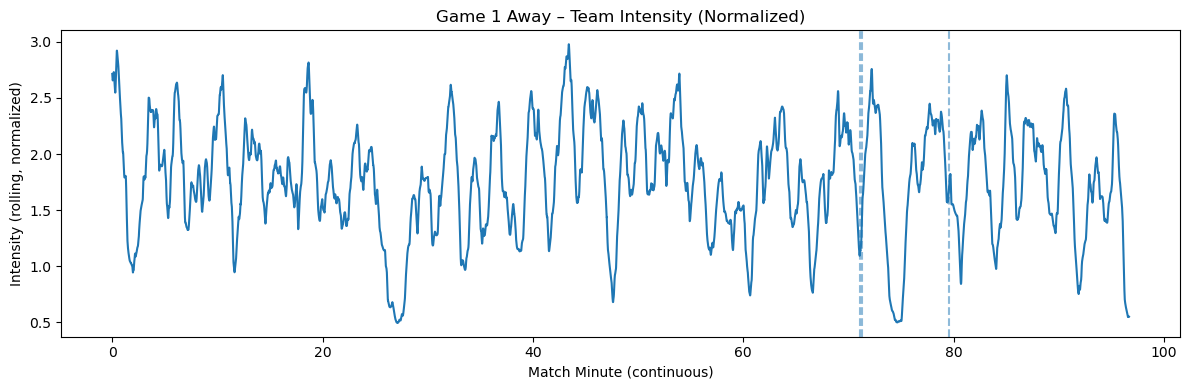

Processing: Game 2 Home
Players detected: 14
Substitutions found: 3


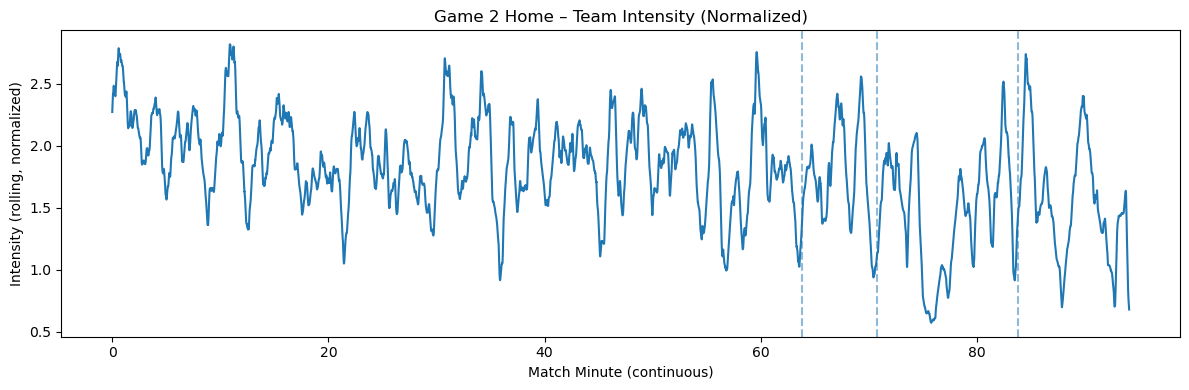

Processing: Game 2 Away
Players detected: 12
Substitutions found: 1


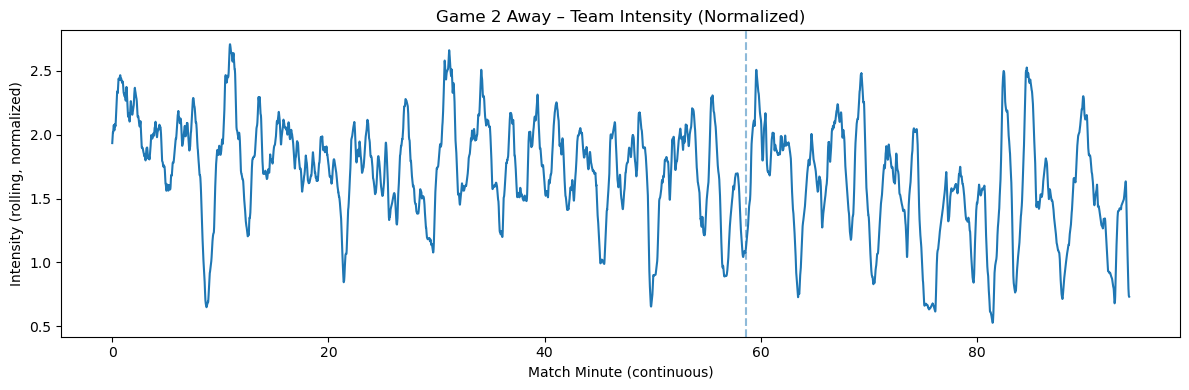

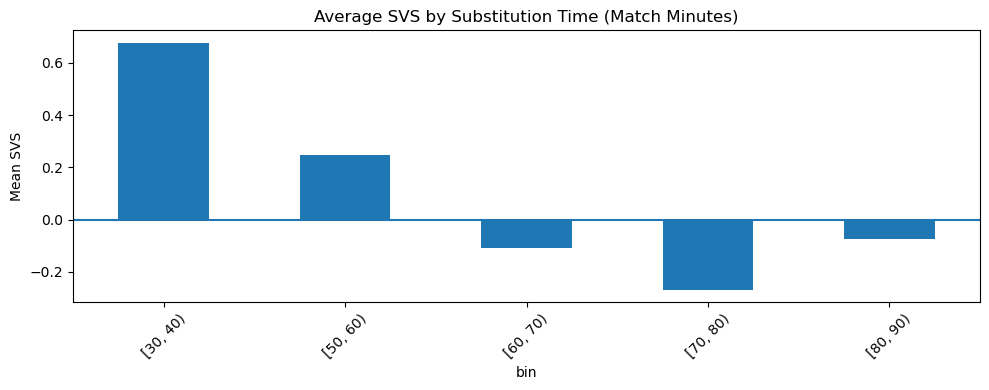

,minute,player_out,player_in,SVS,team,bin
0,31.137000,Player1,Player12,0.676686,Game 1 Home,"[30, 40)"
1,73.898333,Player6,Player13,-0.313218,Game 1 Home,"[70, 80)"
2,80.927000,Player10,Player14,-0.031640,Game 1 Home,"[80, 90)"
3,71.065000,Player24,Player26,-0.262432,Game 1 Away,"[70, 80)"
4,71.245000,Player22,Player27,-0.272406,Game 1 Away,"[70, 80)"
5,79.586333,Player19,Player28,-0.133740,Game 1 Away,"[70, 80)"
6,63.801000,Player4,Player12,-0.108021,Game 2 Home,"[60, 70)"
7,70.739667,Player8,Player13,-0.355215,Game 2 Home,"[70, 80)"
8,83.824333,Player10,Player14,-0.118769,Game 2 Home,"[80, 90)"
9,58.655667,Player22,Player26,0.247336,Game 2 Away,"[50, 60)"


In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# display setting
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 200)

try:
    from IPython.display import display
except Exception:
    display = print

# Global settings
DT = 0.04
PITCH_L = 105
PITCH_W = 68

WINDOW_SEC = 300
BUFFER_SEC = 30
ROLLING_SEC = 60

MAX_SPEED = 10
MATCH_WINDOW_SEC = 10

paths = {"Game 1 Home": "Sample_Game_1_RawTrackingData_Home_Team.csv","Game 1 Away": "Sample_Game_1_RawTrackingData_Away_Team.csv","Game 2 Home": "Sample_Game_2_RawTrackingData_Home_Team.csv","Game 2 Away": "Sample_Game_2_RawTrackingData_Away_Team.csv",}

# Helper functions
def read_and_build_tracking(path: str):
    df_raw = pd.read_csv(path, header=2)
    df = df_raw.iloc[:, :3].copy()
    df.columns = ["Period", "Frame", "Time"]
    cols = list(df_raw.columns)

    i = 3
    while i < len(cols) - 1:
        x_col = cols[i]
        y_col = cols[i + 1]
        if "Unnamed" not in str(x_col) and "Unnamed" in str(y_col):
            name = str(x_col).replace(" ", "")
            df[name + "_x"] = df_raw[x_col]
            df[name + "_y"] = df_raw[y_col]
            i += 2
        else:
            i += 1

    df["Time"] = pd.to_numeric(df["Time"], errors="coerce")
    df["Period"] = pd.to_numeric(df["Period"], errors="coerce")
    df["Frame"] = pd.to_numeric(df["Frame"], errors="coerce")

    players = sorted([c[:-2] for c in df.columns if c.startswith("Player") and c.endswith("_x")])
    return df, players

def to_metric_coordinates(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in out.columns:
        if c.endswith("_x"):
            out[c] = (out[c] - 0.5) * PITCH_L
        elif c.endswith("_y"):
            out[c] = (out[c] - 0.5) * PITCH_W
    return out

def add_match_clock(df: pd.DataFrame) -> pd.DataFrame:
    out = df.sort_values(["Period", "Frame"]).reset_index(drop=True).copy()
    out["match_time_s"] = np.nan
    periods = [p for p in sorted(out["Period"].dropna().unique())]
    running_end = 0.0

    for p in periods:
        g_idx = out.index[out["Period"] == p]
        g = out.loc[g_idx]
        tmin = g["Time"].min()
        tmax = g["Time"].max()
        out.loc[g_idx, "match_time_s"] = (g["Time"] - tmin) + running_end
        running_end += (tmax - tmin)
    return out

def detect_substitutions(df: pd.DataFrame, players: list[str]) -> pd.DataFrame:
    g = df.sort_values(["match_time_s", "Frame"]).reset_index(drop=True)
    t = g["match_time_s"].values
    presence = {p: g[p + "_x"].notna().values for p in players}
    exits = []
    enters = []

    for p in players:
        change = np.diff(presence[p].astype(int))
        exits_idx = np.where(change == -1)[0] + 1
        enters_idx = np.where(change == 1)[0] + 1
        exits.extend([(idx, p) for idx in exits_idx])
        enters.extend([(idx, p) for idx in enters_idx])

    used_enters = set()
    subs = []
    exits = sorted(exits, key=lambda z: t[z[0]])

    for ex_idx, p_out in exits:
        ex_t = t[ex_idx]
        best = None
        for en_idx, p_in in enters:
            if en_idx in used_enters:
                continue
            dt = abs(t[en_idx] - ex_t)
            if dt <= MATCH_WINDOW_SEC:
                if best is None or dt < best[0]:
                    best = (dt, en_idx, p_in)
        if best:
            _, en_idx, p_in = best
            used_enters.add(en_idx)
            sub_time = 0.5 * (ex_t + t[en_idx])
            subs.append({"match_time_s": sub_time, "minute": sub_time / 60.0, "player_out": p_out, "player_in": p_in})

    subs = pd.DataFrame(subs)
    if subs.empty:
        return subs
    return subs.sort_values("match_time_s").reset_index(drop=True)

def compute_team_intensity(df_metric: pd.DataFrame, players: list[str]) -> pd.DataFrame:
    n = len(df_metric)
    team_speed_sum = np.zeros(n, dtype=float)
    active_count = np.zeros(n, dtype=float)

    for p in players:
        x = df_metric[p + "_x"].to_numpy(dtype=float)
        y = df_metric[p + "_y"].to_numpy(dtype=float)
        active = (~np.isnan(x)) & (~np.isnan(y))
        prev_active = np.roll(active, 1)
        prev_active[0] = False
        valid = active & prev_active
        speed = np.full(n, np.nan, dtype=float)
        idx = np.where(valid)[0]
        dx = x[idx] - x[idx - 1]
        dy = y[idx] - y[idx - 1]
        dist = np.sqrt(dx**2 + dy**2)
        s = dist / DT
        s = np.clip(s, 0, MAX_SPEED)
        speed[idx] = s
        active_count += active.astype(float)
        team_speed_sum += np.nan_to_num(speed, nan=0.0)

    intensity_norm = np.where(active_count > 0, team_speed_sum / active_count, np.nan)
    intensity = pd.DataFrame({"match_time_s": df_metric["match_time_s"].to_numpy(dtype=float), "minute": df_metric["match_time_s"].to_numpy(dtype=float) / 60.0, "intensity": intensity_norm, "active_players": active_count})

    roll_n = max(1, int(round(ROLLING_SEC / DT)))
    intensity["intensity_roll"] = intensity["intensity"].rolling(roll_n, center=True, min_periods=1).mean()
    return intensity

def compute_svs(subs: pd.DataFrame, intensity: pd.DataFrame, team_label: str) -> pd.DataFrame:
    if subs.empty:
        return pd.DataFrame([])

    svs_rows = []
    for _, s in subs.iterrows():
        t0 = float(s["match_time_s"])
        before = intensity[(intensity["match_time_s"] >= t0 - WINDOW_SEC) & (intensity["match_time_s"] <  t0 - BUFFER_SEC)]
        after = intensity[(intensity["match_time_s"] >  t0 + BUFFER_SEC) & (intensity["match_time_s"] <= t0 + WINDOW_SEC)]
        if before.empty or after.empty:
            continue

        b = float(before["intensity_roll"].mean())
        a = float(after["intensity_roll"].mean())
        svs_rows.append({"minute": float(s["minute"]), "player_out": s["player_out"], "player_in": s["player_in"], "SVS": a - b, "team": team_label})
    return pd.DataFrame(svs_rows)

def plot_intensity(intensity: pd.DataFrame, subs: pd.DataFrame, title: str):
    plt.figure(figsize=(12, 4))
    plt.plot(intensity["minute"], intensity["intensity_roll"])
    if not subs.empty:
        for _, s in subs.iterrows():
            plt.axvline(float(s["minute"]), linestyle="--", alpha=0.5)
    plt.title(title)
    plt.xlabel("Match Minute (continuous)")
    plt.ylabel("Intensity (rolling, normalized)")
    plt.tight_layout()
    plt.show()

# Main loop
all_svs = []

for label, path in paths.items():
    print("Processing:", label)
    df, players = read_and_build_tracking(path)
    print("Players detected:", len(players))
    df = add_match_clock(df)
    subs = detect_substitutions(df, players)
    print("Substitutions found:", len(subs))
    df_metric = to_metric_coordinates(df)
    intensity = compute_team_intensity(df_metric, players)
    svs = compute_svs(subs, intensity, team_label=label)
    all_svs.append(svs)
    plot_intensity(intensity, subs, title=f"{label} – Team Intensity (Normalized)")

# Combined results and binning plot
svs_all = pd.concat(all_svs, ignore_index=True) if len(all_svs) else pd.DataFrame([])
if svs_all.empty:
    print("\nNo SVS results to bin/plot.")
else:
    bins = np.arange(0, 121, 10)  # 0-120
    svs_all["bin"] = pd.cut(svs_all["minute"], bins=bins, right=False, include_lowest=True)
    summary = svs_all.groupby("bin", observed=True)["SVS"].mean()
    plt.figure(figsize=(10, 4))
    summary.plot(kind="bar")
    plt.axhline(0)
    plt.title("Average SVS by Substitution Time (Match Minutes)")
    plt.ylabel("Mean SVS")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    display(svs_all.head(10))
